In [37]:
!pip install torchinfo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import seaborn as sns
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.image as mpimg
import random
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score,recall_score,f1_score
from torchvision.transforms import v2
from PIL import Image
from torch.utils.data import ConcatDataset
import time
# from torchmetrics import Accuracy

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/cnn_dataset.zip -d /content/cnn_dataset

## PLOT METHODS

In [3]:
def print_confusion_matrix(true_test, test_predicted):
    matrix = confusion_matrix(true_test, test_predicted)
    plt.figure(figsize=(16,14))
    sns.heatmap(matrix, annot=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def print_accuracy_plot(train_accuracies, val_accuracies, accuracy_test, num_epochs=3):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
    plt.axhline(y=accuracy_test, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('No of Epochs')
    plt.ylabel('Accuracies')
    plt.title('Accuracies for Train, Test and Validation')
    plt.legend()
    plt.show()

def print_losses_plot(train_losses, val_losses, test_loss, num_epochs=3):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('No of Epochs')
    plt.ylabel('Losses')
    plt.title('Plot: Train, Test and Validation Losses')
    plt.legend()
    plt.show()

## PART I: VGG NETWORK

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
data_dir = 'cnn_dataset/cnn_dataset'
df = datasets.ImageFolder(root=data_dir, transform=transform)

In [6]:
data_loader = torch.utils.data.DataLoader(df, batch_size=64, shuffle=True)
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
test_size = len(df) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    df, [train_size, val_size, test_size]
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = len(df.classes)
print(f"Number of classes: {num_classes}")

print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

Number of classes: 3
Training set size: 21000
Validation set size: 4500
Test set size: 4500


In [7]:
class VGG13Network(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, num_classes)
            # nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    # def summary(self):
    #     return summary(vgg13)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg13 = VGG13Network()
vgg13.to(device)



cuda


VGG13Network(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [8]:
optimizer = optim.Adamax(vgg13.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [36]:
summary(vgg13)

Layer (type:depth-idx)                   Param #
VGG13Network                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      1,180,160
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      2,359,808
│    └─ReLU: 2-19                

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        total_val = 0
        correct_val = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy =  100 * correct_train / total_train
        # print("TRAIIIIN", train_accuracy)
        train_accuracies.append(train_accuracy)
        # Validation loss
        model.eval()
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            _, predicted_val = torch.max(outputs, 1)
            correct_val += (predicted_val == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy}\tValidation Accuracy: {val_accuracy}')

    return train_losses, val_losses, train_accuracies, val_accuracies



In [25]:
train_losses, val_losses, train_accuracies, val_accuracies = train(vgg13, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch 1, Training Loss: 0.7918, Validation Loss: 0.5953
Train Accuracy: 60.285714285714285	Validation Accuracy: 73.2
Epoch 2, Training Loss: 0.5677, Validation Loss: 0.4548
Train Accuracy: 76.14285714285714	Validation Accuracy: 81.4888888888889
Epoch 3, Training Loss: 0.4608, Validation Loss: 0.4096
Train Accuracy: 81.24761904761905	Validation Accuracy: 84.04444444444445
Epoch 4, Training Loss: 0.3743, Validation Loss: 0.3270
Train Accuracy: 85.21428571428571	Validation Accuracy: 86.77777777777777
Epoch 5, Training Loss: 0.3302, Validation Loss: 0.6629
Train Accuracy: 87.25714285714285	Validation Accuracy: 78.0


In [27]:
test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.squeeze(1)
        outputs = vgg13(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_matrix = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print('Basic model results for VGG13')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Basic model results for VGG13
Accuracy:  78.2
Confusion Matrix:  [[1441   40    5]
 [ 512 1011   10]
 [ 270  144 1067]]
Precision:  82.67950034145564
Recall:  78.32225683356756
F1 Score:  78.36164068461406


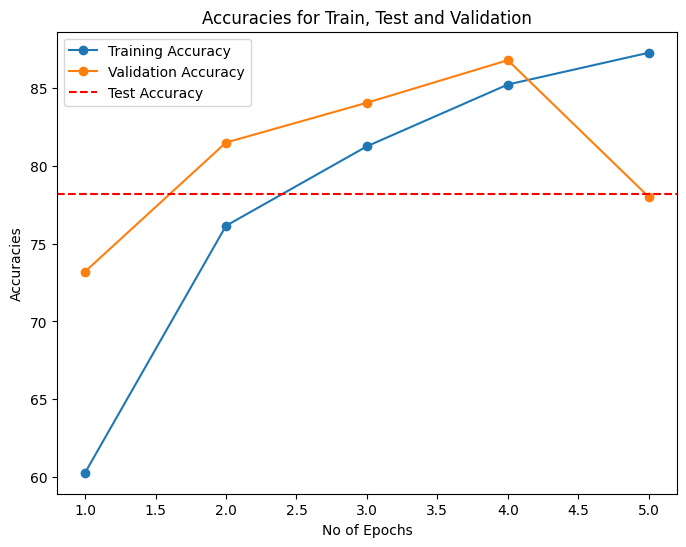

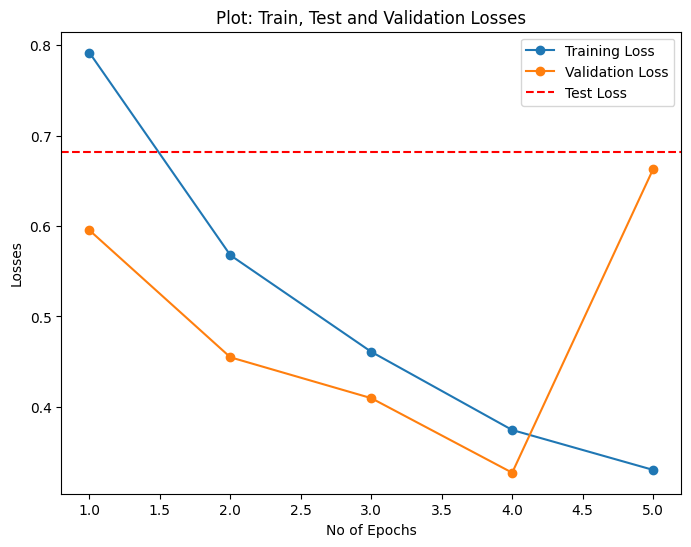

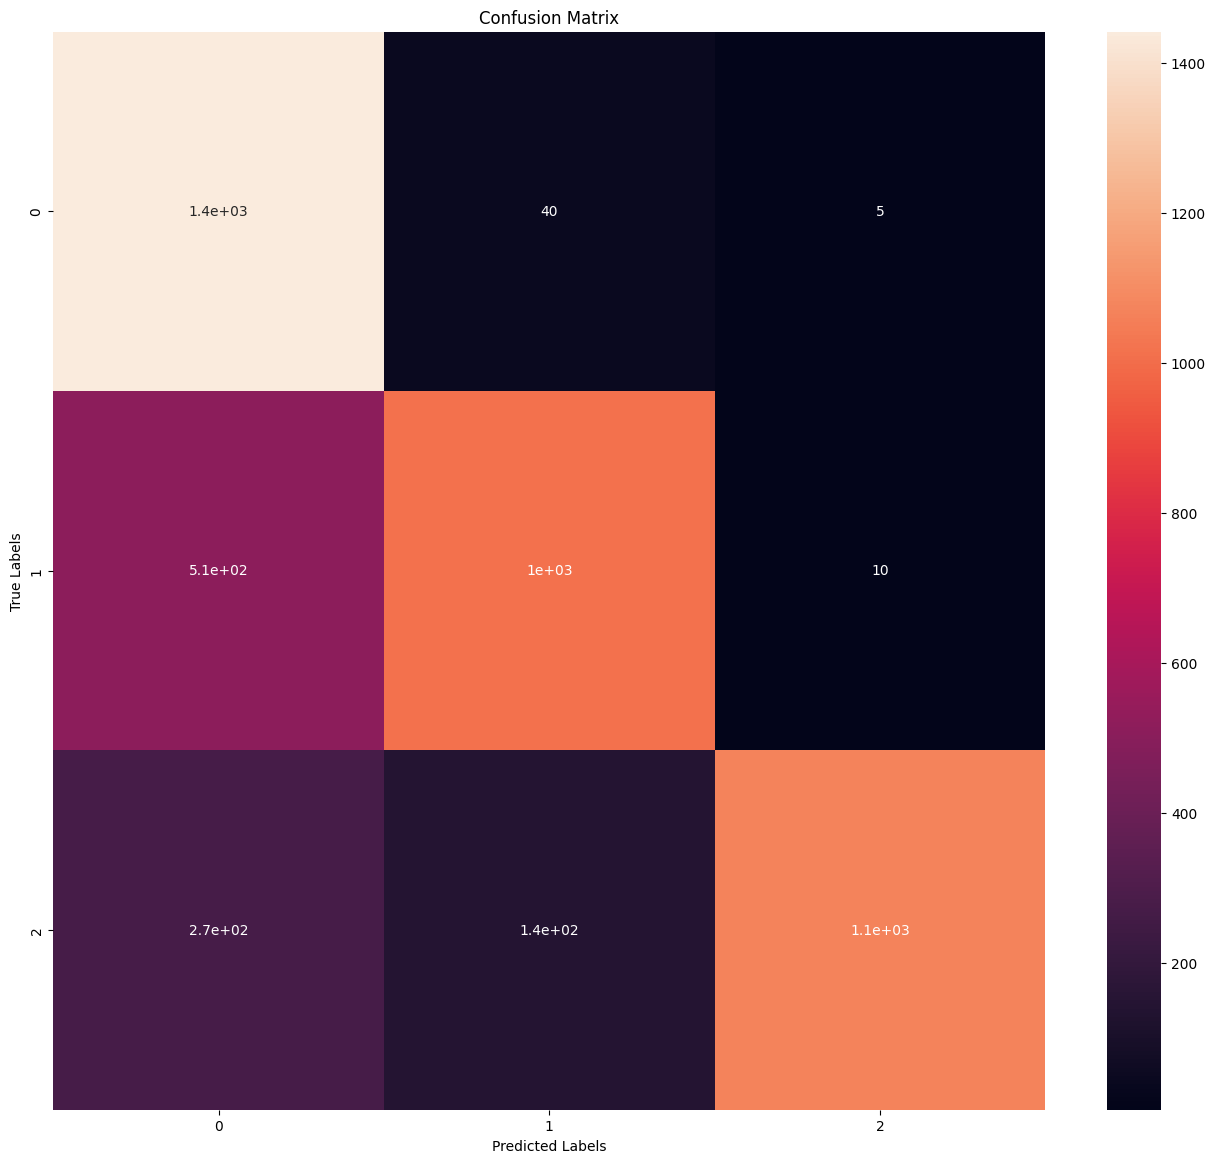

In [28]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 5)
print_losses_plot(train_losses, val_losses, test_average_loss, 5)
print_confusion_matrix(total_correct_pred, test_pred)


### DATA AUGMENTATION

In [29]:
transforms_augmentation = v2.Compose([
    v2.RandomResizedCrop(size=(32, 32), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, ], std=[0.5, ]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [30]:
augdf = datasets.ImageFolder(root=data_dir, transform=transforms_augmentation)

In [31]:
aug_data_loader = torch.utils.data.DataLoader(augdf, batch_size=64, shuffle=True)
aug_train_size = int(0.7 * len(augdf))
aug_val_size = int(0.15 * len(augdf))
aug_test_size = len(augdf) - train_size - val_size

aug_train_dataset, aug_val_dataset, aug_test_dataset = torch.utils.data.random_split(
    augdf, [train_size, val_size, test_size]
)

aug_train_loader = torch.utils.data.DataLoader(aug_train_dataset, batch_size=64, shuffle=True)
aug_val_loader = torch.utils.data.DataLoader(aug_val_dataset, batch_size=64, shuffle=False)
aug_test_loader = torch.utils.data.DataLoader(aug_test_dataset, batch_size=64, shuffle=False)

num_classes = len(augdf.classes)

In [32]:
class VGG13Aug(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13Aug, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, num_classes)
            # nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    # def summary(self):
    #     return summary(vgg13)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg_aug = VGG13Aug()
vgg_aug.to(device)

cuda


VGG13Aug(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (

In [33]:
optimizer = optim.Adamax(vgg_aug.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [34]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        total_val = 0
        correct_val = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy =  100 * correct_train / total_train
        # print("TRAIIIIN", train_accuracy)
        train_accuracies.append(train_accuracy)
        # Validation loss
        model.eval()
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            _, predicted_val = torch.max(outputs, 1)
            correct_val += (predicted_val == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy}\tValidation Accuracy: {val_accuracy}')

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train(vgg_aug, aug_train_loader, aug_val_loader, criterion, optimizer, epochs=10)


Epoch 1, Training Loss: 0.9659, Validation Loss: 0.8447
Train Accuracy: 48.45238095238095	Validation Accuracy: 60.8
Epoch 2, Training Loss: 0.7963, Validation Loss: 0.7225
Train Accuracy: 64.0	Validation Accuracy: 68.68888888888888
Epoch 3, Training Loss: 0.7070, Validation Loss: 0.6683
Train Accuracy: 68.83809523809524	Validation Accuracy: 72.33333333333333
Epoch 4, Training Loss: 0.6486, Validation Loss: 0.6650
Train Accuracy: 72.69047619047619	Validation Accuracy: 71.31111111111112
Epoch 5, Training Loss: 0.6017, Validation Loss: 0.5685
Train Accuracy: 75.27142857142857	Validation Accuracy: 76.4
Epoch 6, Training Loss: 0.5808, Validation Loss: 0.7712
Train Accuracy: 75.6	Validation Accuracy: 69.55555555555556
Epoch 7, Training Loss: 0.5476, Validation Loss: 0.6260
Train Accuracy: 77.3047619047619	Validation Accuracy: 74.31111111111112
Epoch 8, Training Loss: 0.5310, Validation Loss: 0.5166
Train Accuracy: 78.3047619047619	Validation Accuracy: 79.04444444444445
Epoch 9, Training Loss

In [35]:
# TESTING
test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in aug_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.squeeze(1)
        outputs = vgg_aug(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_matrix = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print('Data Augmentation for VGG13')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Data Augmentation for VGG13
Accuracy:  76.95555555555555
Confusion Matrix:  [[1131  135  215]
 [ 289  936  322]
 [  39   37 1396]]
Precision:  78.07157699529776
Recall:  77.2361591937365
F1 Score:  76.48143774297095


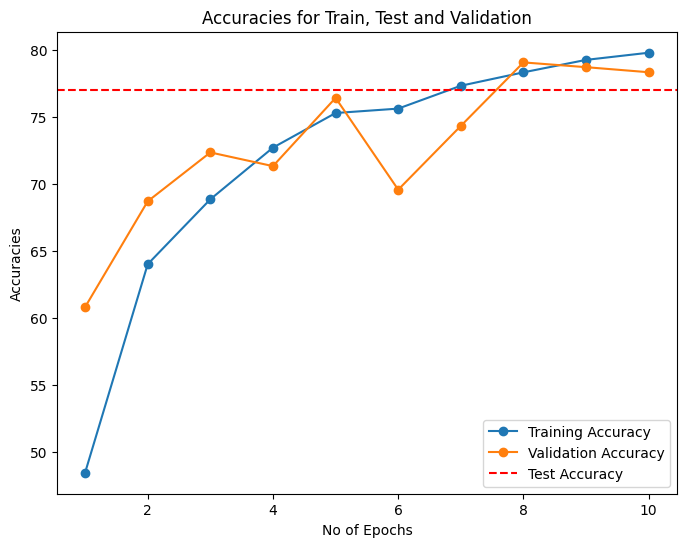

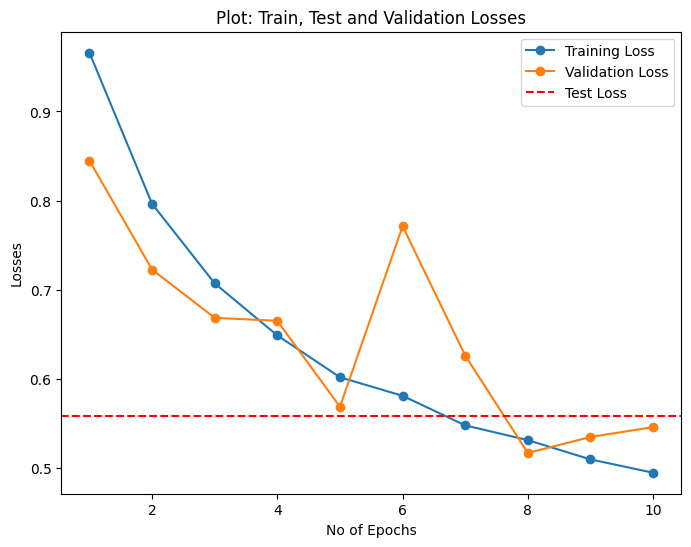

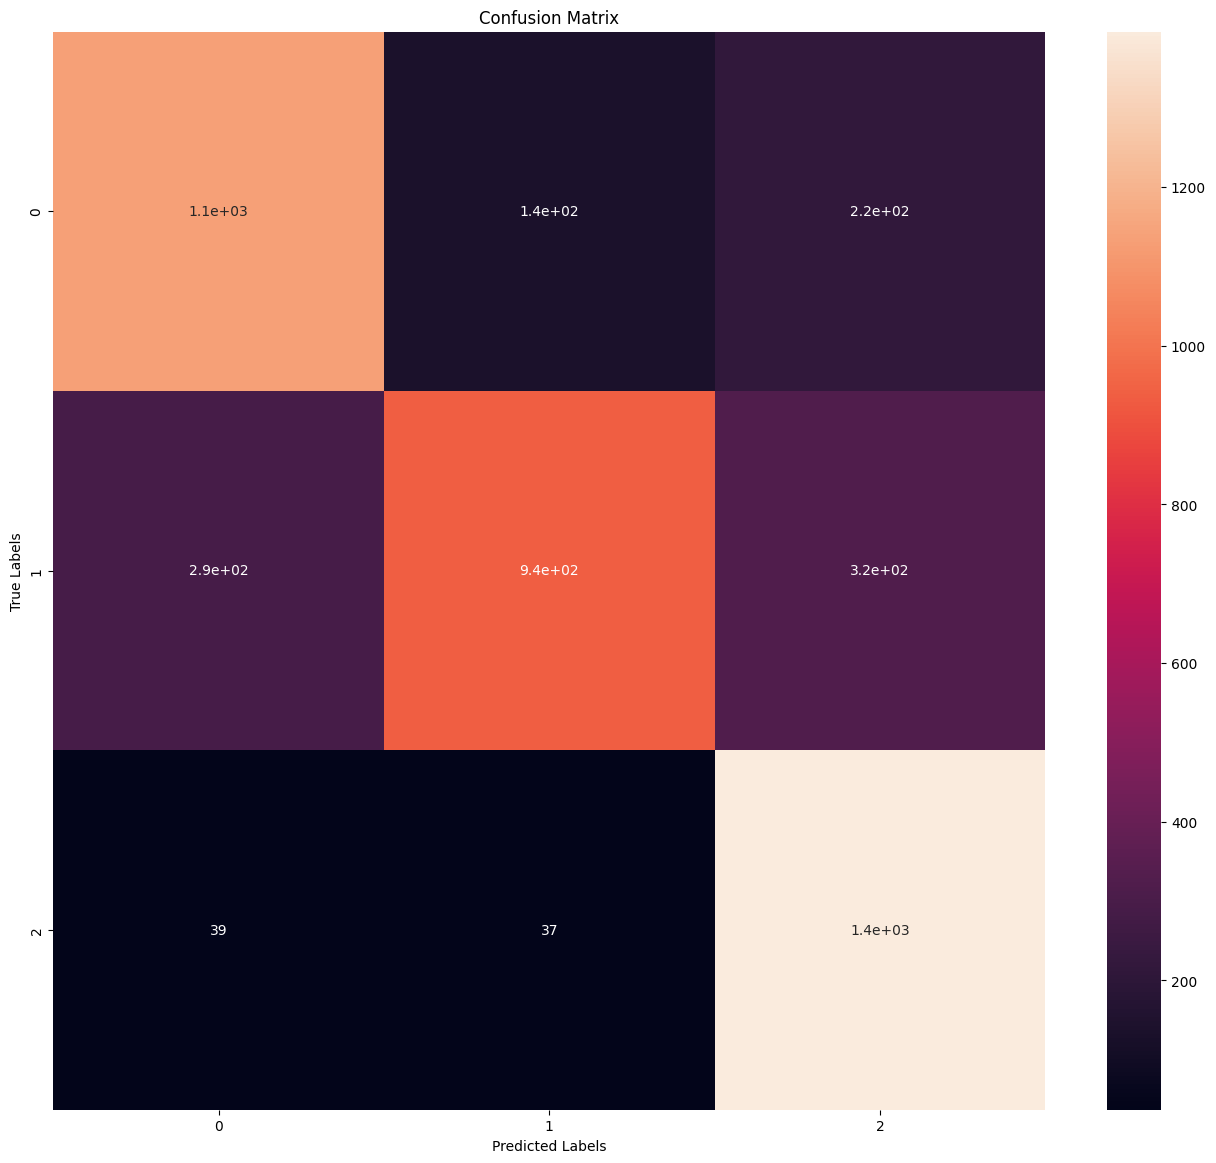

In [36]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 10)
print_losses_plot(train_losses, val_losses, test_average_loss, 10)
print_confusion_matrix(total_correct_pred, test_pred)

### L2 REGULARIZATION

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regularization_model = VGG13Network()
regularization_model.to(device)
optimizer_l2 = optim.Adamax(regularization_model.parameters(), lr=0.001, weight_decay=0.000001)

train_losses, val_losses, train_accuracies, val_accuracies = train(regularization_model, train_loader, val_loader, criterion, optimizer_l2, epochs=5)
test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.squeeze(1)
        outputs = regularization_model(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_matrix = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print('L2 Regularization technique for VGG13')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Epoch 1, Training Loss: 0.7672, Validation Loss: 0.7126
Train Accuracy: 59.72380952380952	Validation Accuracy: 68.26666666666667
Epoch 2, Training Loss: 0.5851, Validation Loss: 0.5804
Train Accuracy: 75.07619047619048	Validation Accuracy: 74.64444444444445
Epoch 3, Training Loss: 0.4933, Validation Loss: 0.4638
Train Accuracy: 80.10952380952381	Validation Accuracy: 81.6
Epoch 4, Training Loss: 0.3793, Validation Loss: 0.3922
Train Accuracy: 85.07619047619048	Validation Accuracy: 83.57777777777778
Epoch 5, Training Loss: 0.3230, Validation Loss: 0.3541
Train Accuracy: 87.76666666666667	Validation Accuracy: 86.13333333333334
L2 Regularization technique for VGG13
Accuracy:  86.84444444444445
Confusion Matrix:  [[1389   81   19]
 [ 288 1173   42]
 [  90   72 1346]]
Precision:  87.57796092641391
Recall:  86.86176329424143
F1 Score:  86.86538460813657


In [12]:
print(device)

cuda


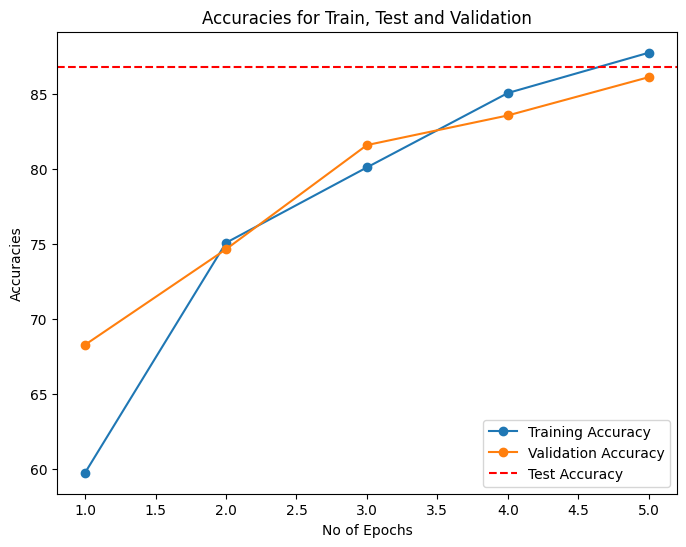

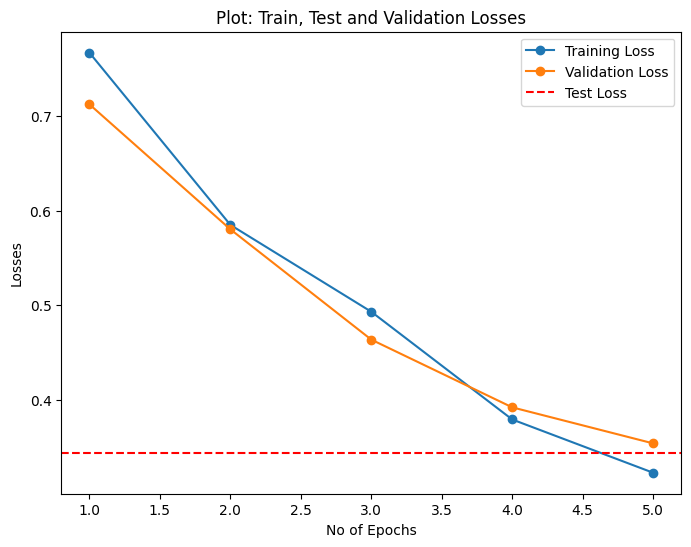

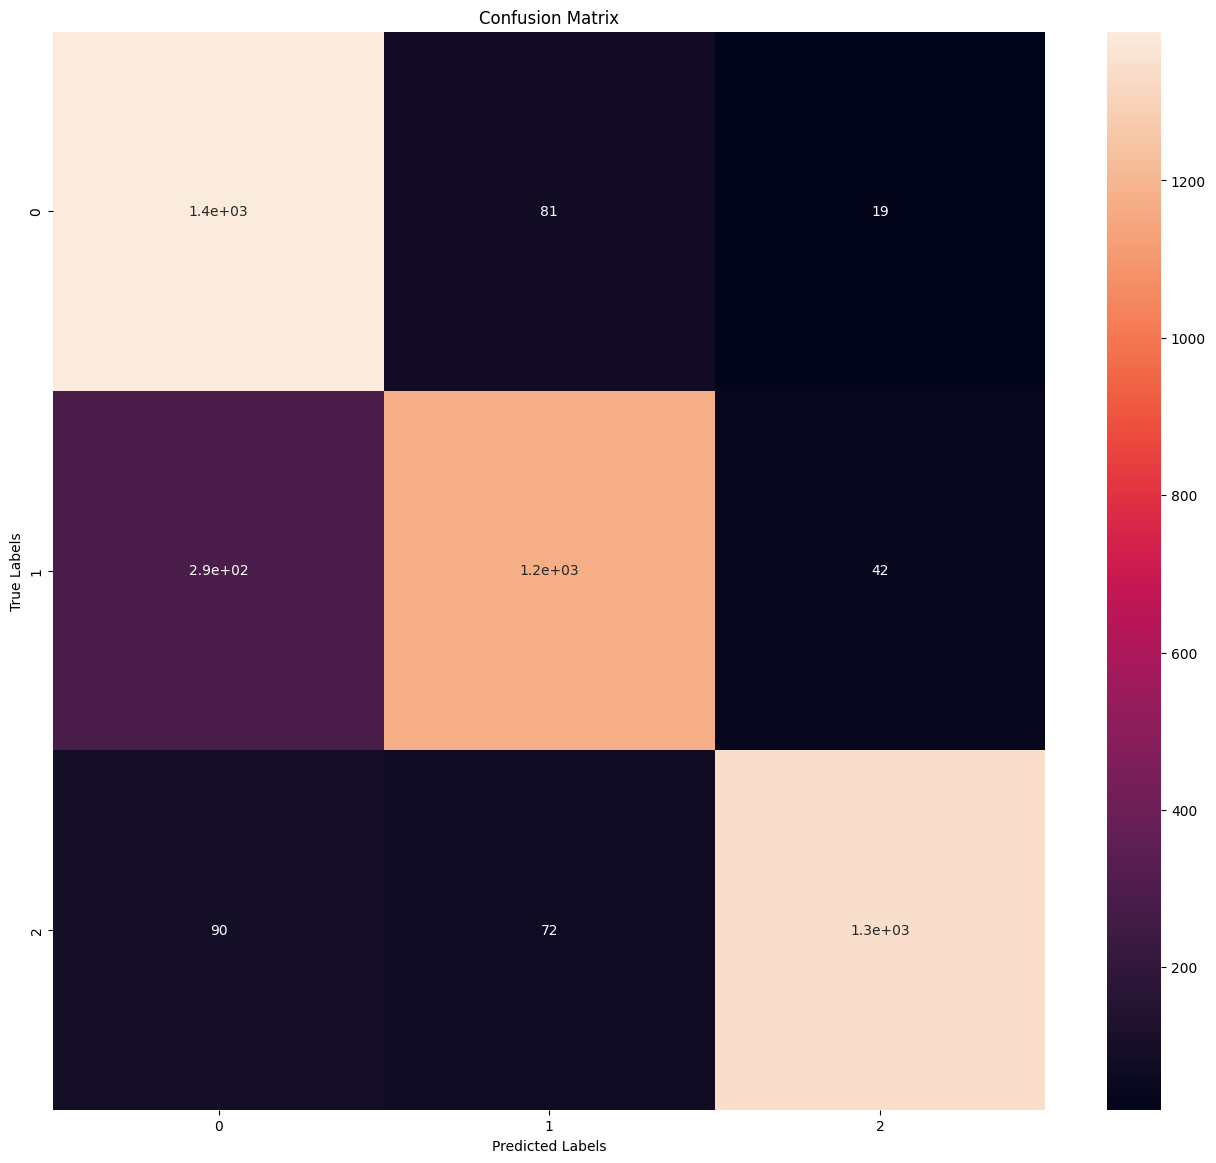

In [11]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 5)
print_losses_plot(train_losses, val_losses, test_average_loss, 5)
print_confusion_matrix(total_correct_pred, test_pred)


### EARLY STOPPING

In [13]:
# Early stopping

def earlystop_train(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    best_val_accuracy = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        correct_val = 0
        total_train = 0
        total_val = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy =  100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        # Validation loss
        model.eval()
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            outputs = model(inputs)
            _, predicted_val = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy =  100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_early_model.pth')


        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy}\tValidation Accuracy: {val_accuracy}')
    return train_losses, val_losses, train_accuracies, val_accuracies

early_model = VGG13Network()
early_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_early = optim.Adamax(early_model.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = earlystop_train(early_model, train_loader, val_loader, criterion, optimizer_early, epochs=5)
best_early_model = VGG13Network()
best_early_model.load_state_dict(torch.load('best_early_model.pth'))
best_early_model.to(device)

test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.squeeze(1)
        outputs = best_early_model(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_matrix = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print('Early Stopping technique for VGG13')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Epoch 1/5, Training Loss: 0.7989, Validation Loss: 0.6416
Train Accuracy: 59.4	Validation Accuracy: 73.02222222222223
Epoch 2/5, Training Loss: 0.5623, Validation Loss: 0.7048
Train Accuracy: 76.8952380952381	Validation Accuracy: 72.53333333333333
Epoch 3/5, Training Loss: 0.4665, Validation Loss: 0.4228
Train Accuracy: 81.1952380952381	Validation Accuracy: 83.4888888888889
Epoch 5/5, Training Loss: 0.3262, Validation Loss: 0.3721
Train Accuracy: 87.44761904761904	Validation Accuracy: 85.71111111111111
Early Stopping technique for VGG13
Accuracy:  85.77777777777777
Confusion Matrix:  [[1129  345   15]
 [  53 1435   15]
 [  36  176 1296]]
Precision:  87.93150132856948
Recall:  85.74668653235032
F1 Score:  85.94872089855046


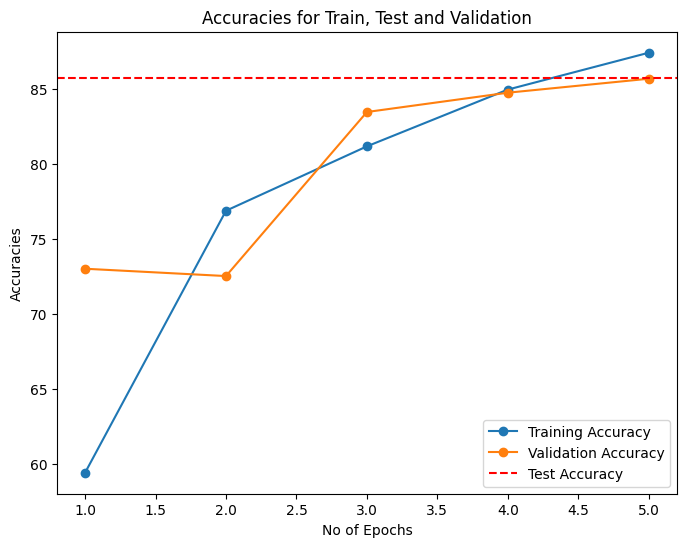

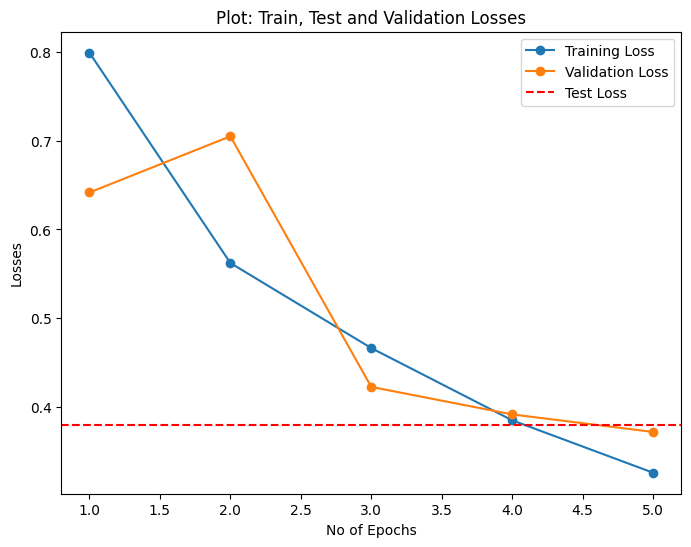

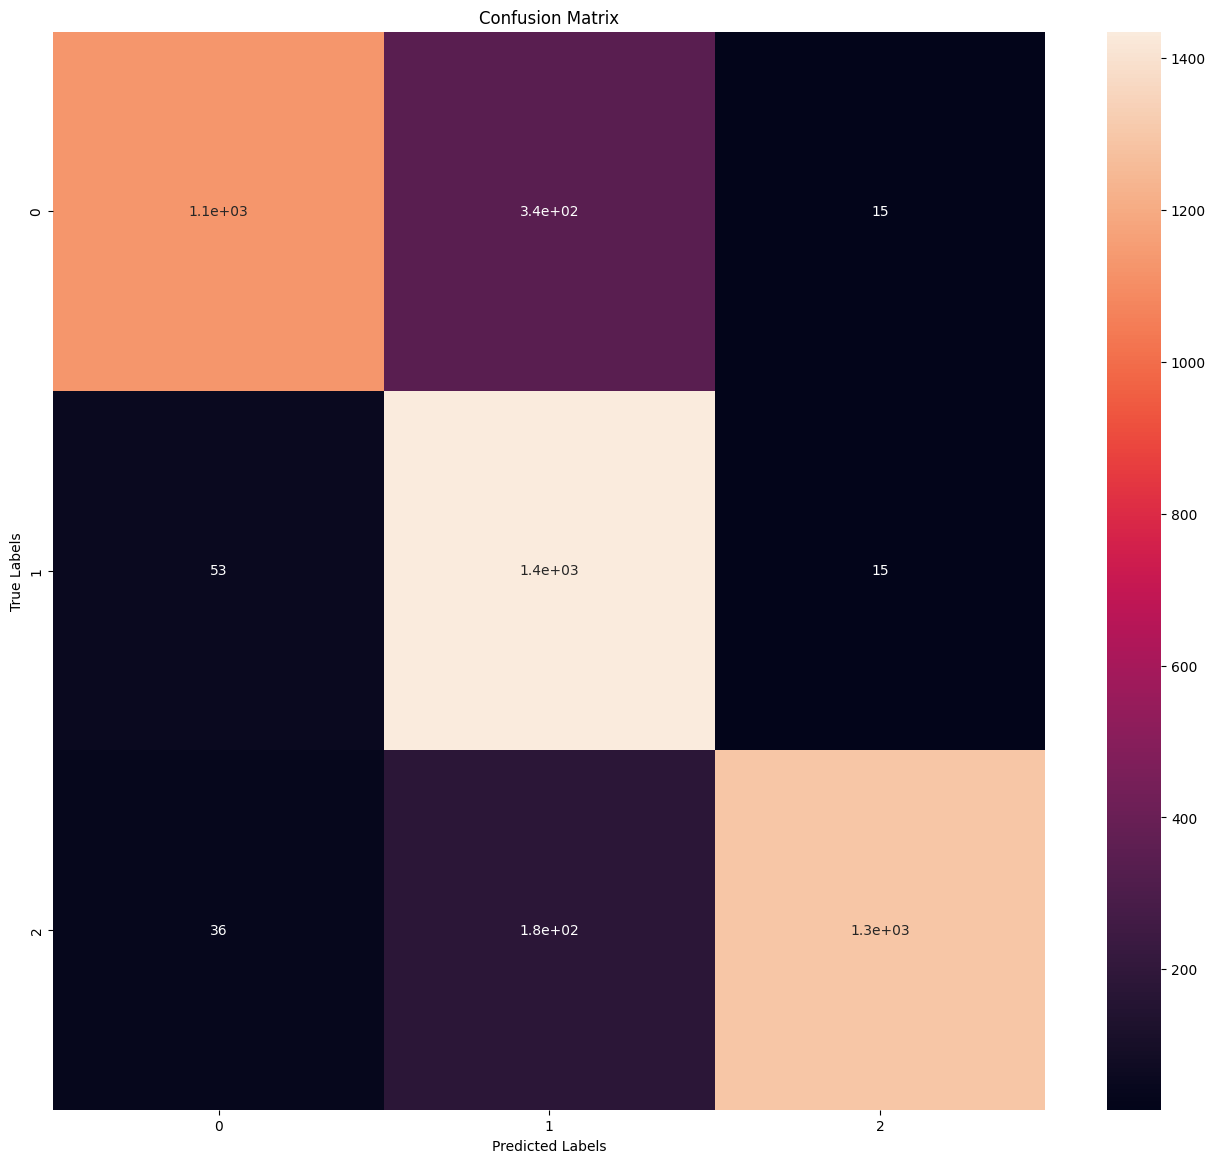

In [14]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 5)
print_losses_plot(train_losses, val_losses, test_average_loss, 5)
print_confusion_matrix(total_correct_pred, test_pred)


### DROPOUTS

In [16]:
class VGG13Drop(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13Drop, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1000, num_classes)
            # nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    def summary(self):
        return summary(vgg13)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drop_model = VGG13Drop()
drop_model.to(device)
print(drop_model.summary())

criterion = nn.CrossEntropyLoss()
optimizer_drop = optim.Adamax(drop_model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = train(drop_model, train_loader, val_loader, criterion, optimizer_drop, epochs=5)

test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.squeeze(1)
        outputs = drop_model(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_matrix = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print('Dropout technique for VGG13')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)


Layer (type:depth-idx)                   Param #
VGG13Network                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      1,180,160
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      2,359,808
│    └─ReLU: 2-19                

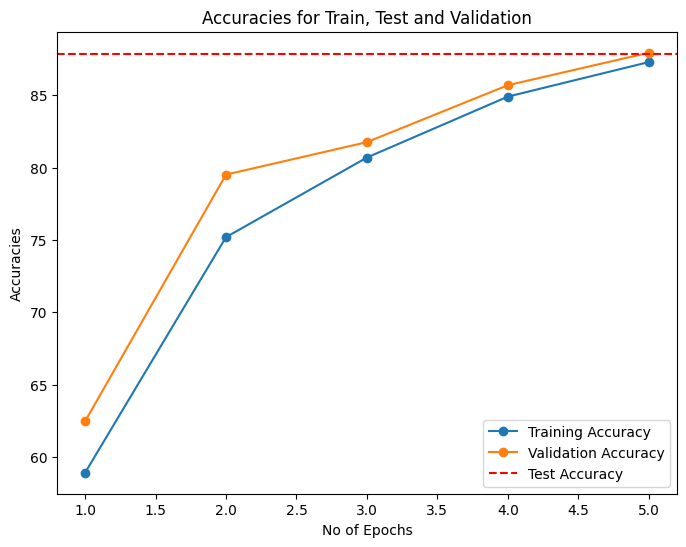

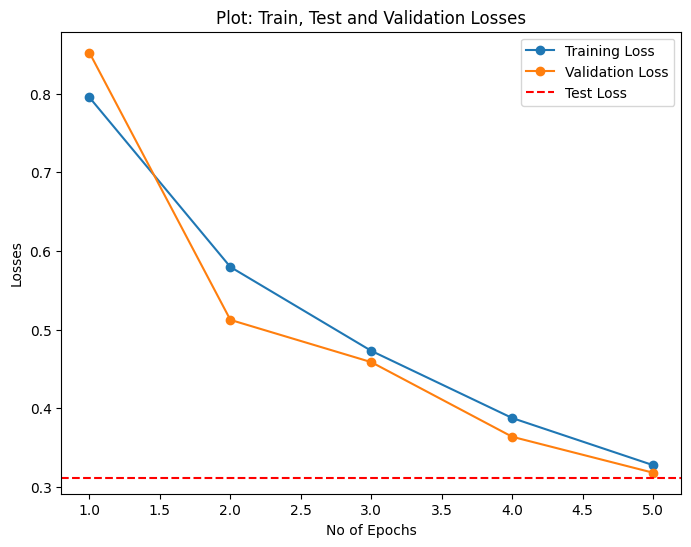

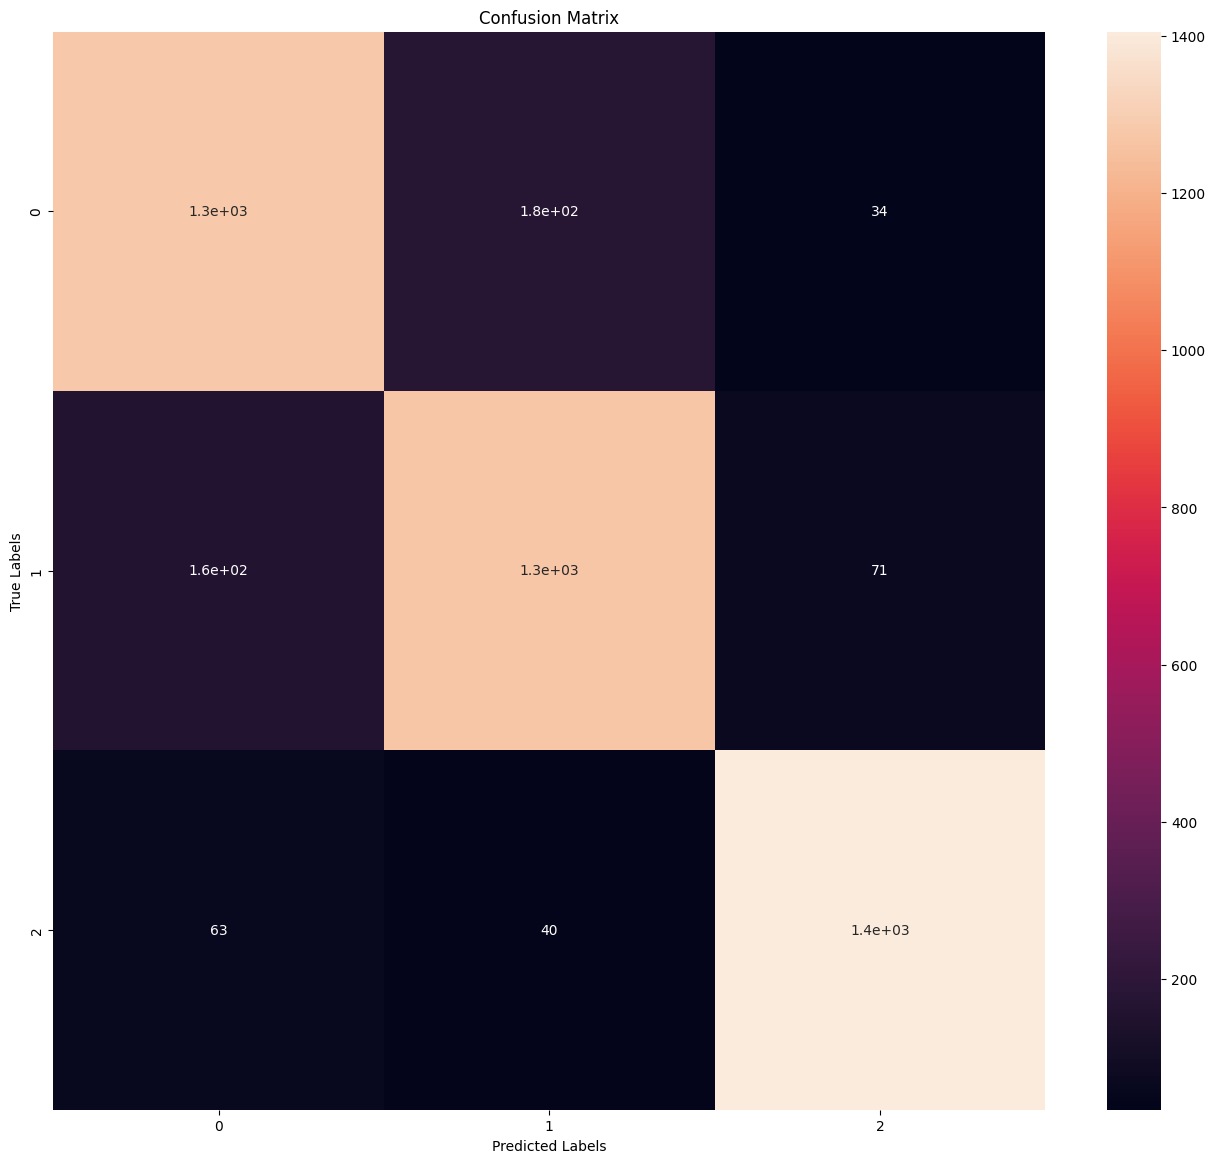

In [17]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 5)
print_losses_plot(train_losses, val_losses, test_average_loss, 5)
print_confusion_matrix(total_correct_pred, test_pred)


In [34]:
torch.save(drop_model.state_dict(), 'cnara_neemageo_assignment1_part1.h5')


## PART II: RESNET

In [18]:
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [19]:
class ResNet18(nn.Module):
    def __init__(self, block, num_classes=3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, 2)
        self.layer2 = self.make_layer(block, 128, 2, stride=2)
        self.layer3 = self.make_layer(block, 256, 2, stride=2)
        self.layer4 = self.make_layer(block, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
res18 = ResNet18(ResidualBlock).to(device)

cuda


In [39]:
summary(res18)

Layer (type:depth-idx)                   Param #
ResNet18                                 --
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─ResidualBlock: 2-1                --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─ResidualBlock: 2-2                --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─ResidualBlock: 2-3                --
│    │    └─Conv2d: 3-11                 73,728

In [20]:
optimizer = optim.Adamax(res18.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [21]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        total_val = 0
        correct_val = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy =  100 * correct_train / total_train
        # print("TRAIIIIN", train_accuracy)
        train_accuracies.append(train_accuracy)
        # Validation loss
        model.eval()
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            _, predicted_val = torch.max(outputs, 1)
            correct_val += (predicted_val == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy}\tValidation Accuracy: {val_accuracy}')

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train(res18, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1, Training Loss: 0.5367, Validation Loss: 0.4793
Train Accuracy: 77.66666666666667	Validation Accuracy: 80.86666666666666
Epoch 2, Training Loss: 0.3670, Validation Loss: 0.3946
Train Accuracy: 85.46190476190476	Validation Accuracy: 84.82222222222222
Epoch 3, Training Loss: 0.2978, Validation Loss: 0.3369
Train Accuracy: 88.42857142857143	Validation Accuracy: 86.42222222222222
Epoch 4, Training Loss: 0.2376, Validation Loss: 0.3326
Train Accuracy: 90.95238095238095	Validation Accuracy: 86.97777777777777
Epoch 5, Training Loss: 0.1887, Validation Loss: 0.3437
Train Accuracy: 92.89047619047619	Validation Accuracy: 87.33333333333333
Epoch 6, Training Loss: 0.1244, Validation Loss: 0.4414
Train Accuracy: 95.4	Validation Accuracy: 85.4888888888889
Epoch 7, Training Loss: 0.0755, Validation Loss: 0.5216
Train Accuracy: 97.07142857142857	Validation Accuracy: 85.4888888888889
Epoch 8, Training Loss: 0.0461, Validation Loss: 0.4819
Train Accuracy: 98.31428571428572	Validation Accuracy: 8

In [22]:
# TESTING
test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.squeeze(1)
        outputs = res18(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_matrix = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print('Basic Resnet 18 results')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Basic Resnet 18 results
Accuracy:  87.42222222222222
Confusion Matrix:  [[1260  151   78]
 [ 119 1257  127]
 [  52   39 1417]]
Precision:  87.42699392240111
Recall:  87.40626749249624
F1 Score:  87.35494661215996


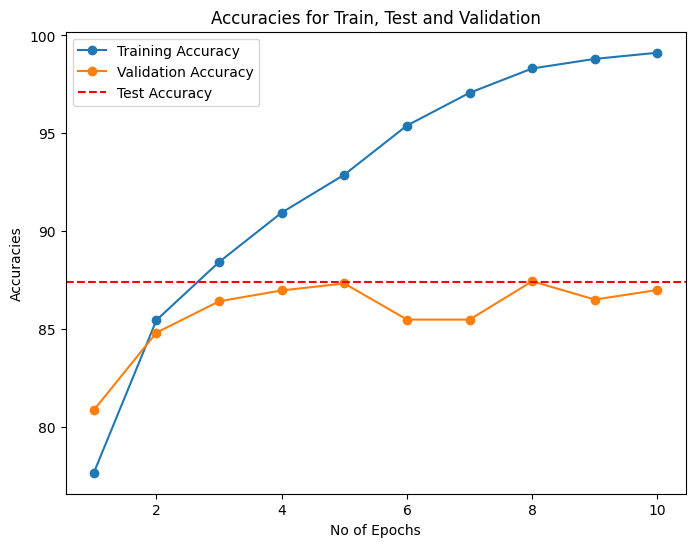

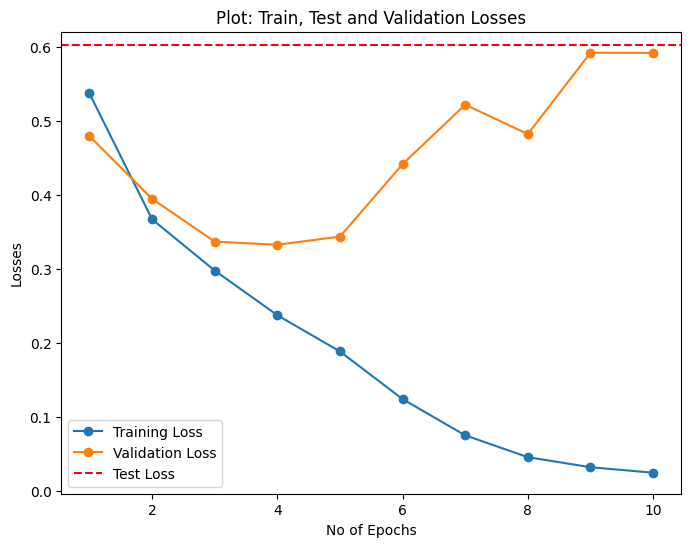

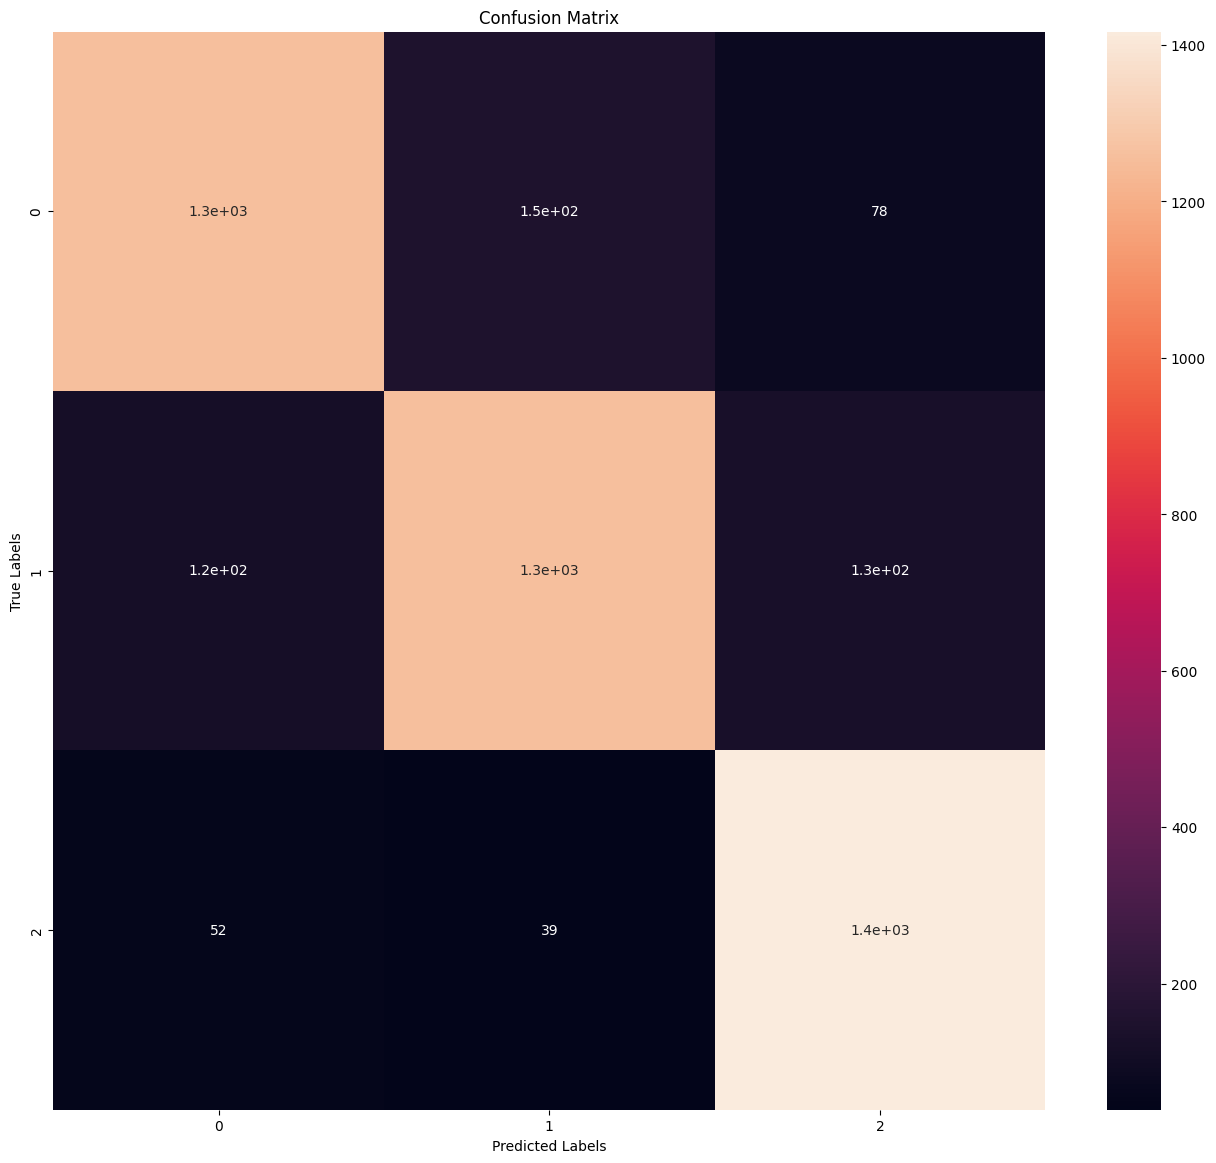

In [23]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 10)
print_losses_plot(train_losses, val_losses, test_average_loss, 10)
print_confusion_matrix(total_correct_pred, test_pred)

### L2 REGULARIZATION

In [25]:
regularization_resnet = ResNet18(ResidualBlock)
regularization_resnet.to(device)
optimizer_l2 = optim.Adamax(regularization_resnet.parameters(), lr=0.001, weight_decay=0.000001)

train_losses, val_losses, train_accuracies, val_accuracies = train(regularization_resnet, train_loader, val_loader, criterion, optimizer_l2, epochs=10)
test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.squeeze(1)
        outputs = regularization_resnet(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_matrix = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print('L2 Regularization for Resnet 18')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Epoch 1, Training Loss: 0.5442, Validation Loss: 0.5225
Train Accuracy: 77.5	Validation Accuracy: 77.95555555555555
Epoch 2, Training Loss: 0.3700, Validation Loss: 0.3679
Train Accuracy: 85.5	Validation Accuracy: 85.95555555555555
Epoch 3, Training Loss: 0.3102, Validation Loss: 0.5560
Train Accuracy: 87.99047619047619	Validation Accuracy: 80.77777777777777
Epoch 4, Training Loss: 0.2420, Validation Loss: 0.3824
Train Accuracy: 90.71428571428571	Validation Accuracy: 86.22222222222223
Epoch 5, Training Loss: 0.1845, Validation Loss: 0.3646
Train Accuracy: 92.88571428571429	Validation Accuracy: 86.82222222222222
Epoch 6, Training Loss: 0.1250, Validation Loss: 0.4067
Train Accuracy: 95.32380952380953	Validation Accuracy: 87.4888888888889
Epoch 7, Training Loss: 0.0884, Validation Loss: 0.6740
Train Accuracy: 96.71904761904761	Validation Accuracy: 81.86666666666666
Epoch 8, Training Loss: 0.0631, Validation Loss: 0.5165
Train Accuracy: 97.56666666666666	Validation Accuracy: 85.0888888888

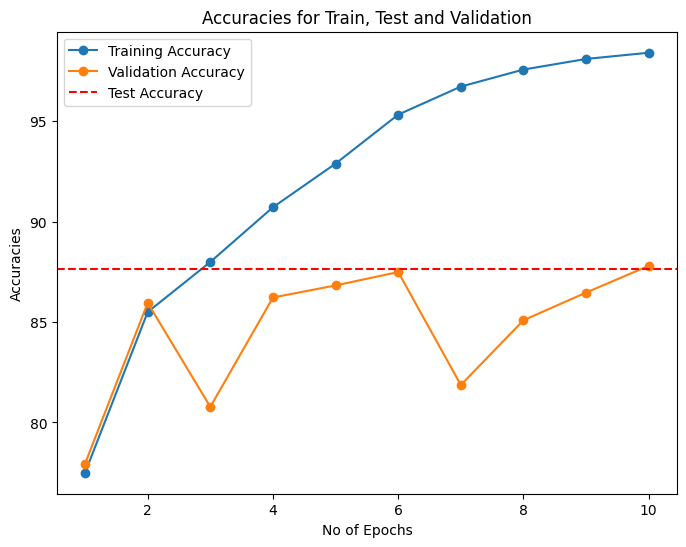

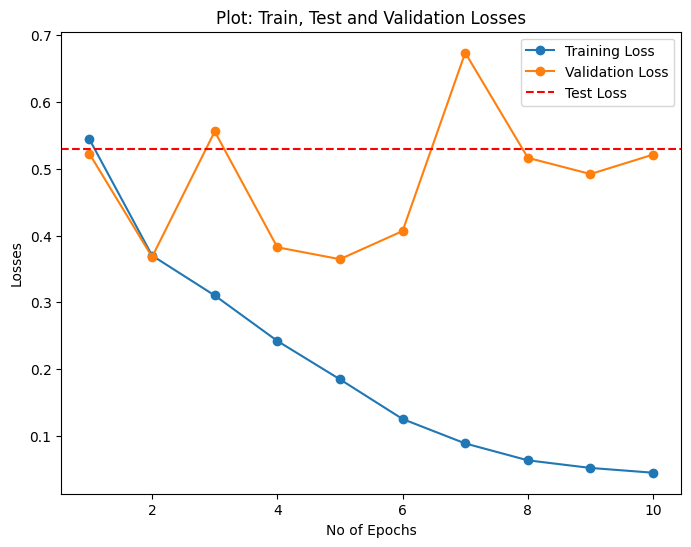

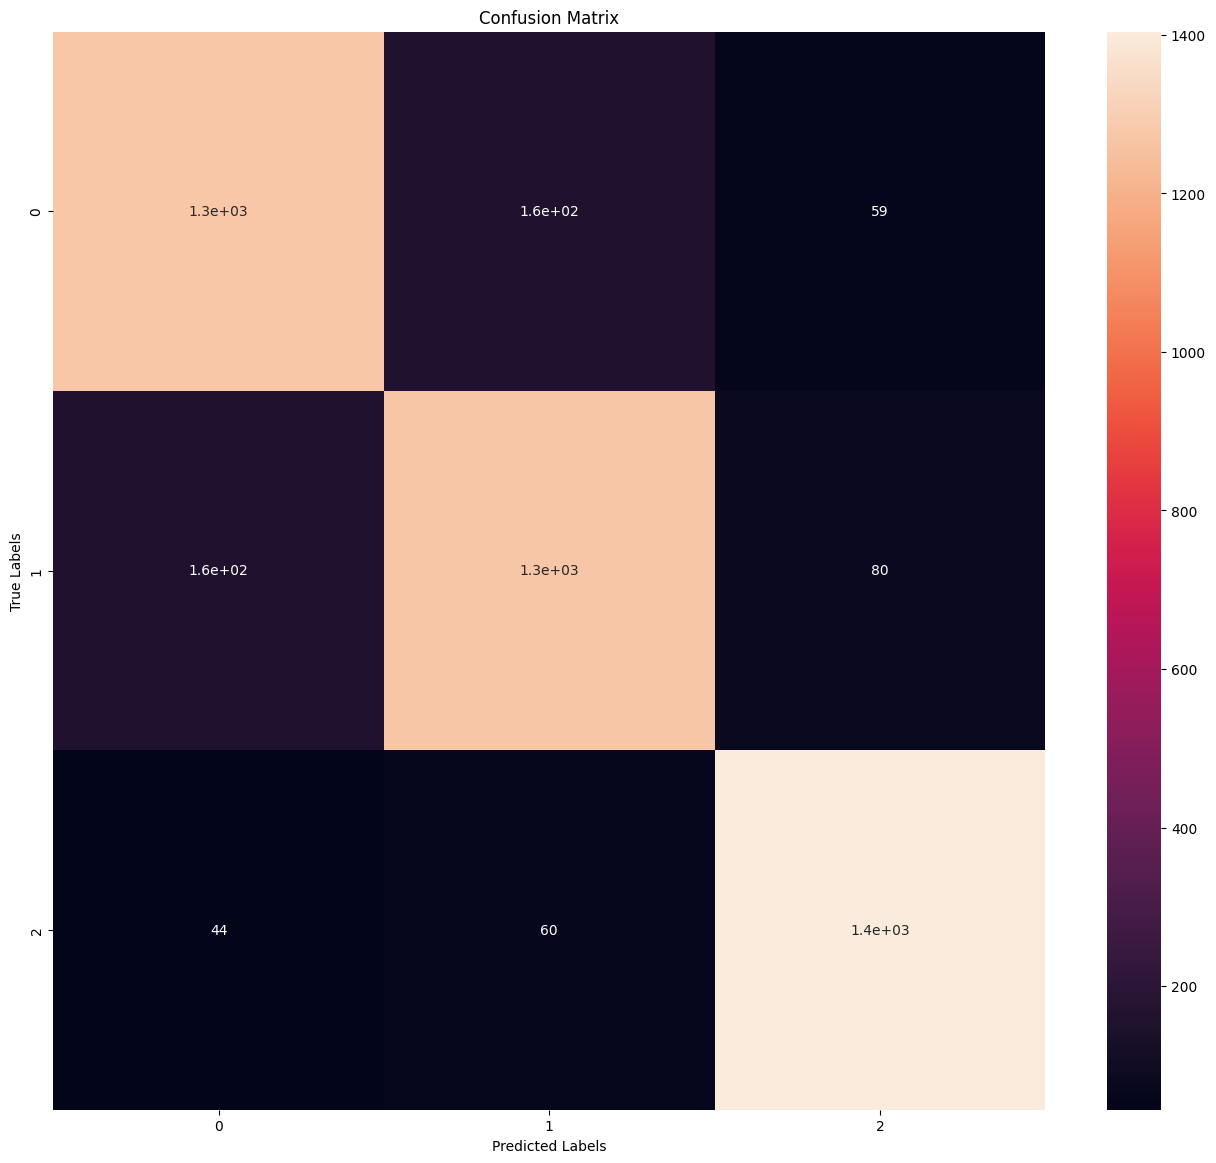

In [26]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 10)
print_losses_plot(train_losses, val_losses, test_average_loss, 10)
print_confusion_matrix(total_correct_pred, test_pred)

### EARLY STOPPING

In [30]:
# Early stopping

def earlystop_train(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    best_val_accuracy = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        correct_val = 0
        total_train = 0
        total_val = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy =  100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        # Validation loss
        model.eval()
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.squeeze(1)
            outputs = model(inputs)
            _, predicted_val = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy =  100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_early_resnet.pth')


        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy}\tValidation Accuracy: {val_accuracy}')
    return train_losses, val_losses, train_accuracies, val_accuracies

early_resnet = ResNet18(ResidualBlock)
early_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_early = optim.Adamax(early_resnet.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = earlystop_train(early_resnet, train_loader, val_loader, criterion, optimizer_early, epochs=10)
best_early_resnet = ResNet18(ResidualBlock)
best_early_resnet.load_state_dict(torch.load('best_early_resnet.pth'))
best_early_resnet.to(device)

test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.squeeze(1)
        outputs = best_early_resnet(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_matrix = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print('Early Stopping technique for Resnet 18')
print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_matrix)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Epoch 1/10, Training Loss: 0.5488, Validation Loss: 0.7141
Train Accuracy: 77.07619047619048	Validation Accuracy: 70.08888888888889
Epoch 2/10, Training Loss: 0.3756, Validation Loss: 0.4243
Train Accuracy: 85.27142857142857	Validation Accuracy: 83.13333333333334
Epoch 3/10, Training Loss: 0.3143, Validation Loss: 0.3448
Train Accuracy: 87.91904761904762	Validation Accuracy: 86.86666666666666
Epoch 4/10, Training Loss: 0.2520, Validation Loss: 0.3845
Train Accuracy: 90.45238095238095	Validation Accuracy: 86.11111111111111
Epoch 5/10, Training Loss: 0.1911, Validation Loss: 0.6068
Train Accuracy: 92.8	Validation Accuracy: 80.55555555555556
Epoch 6/10, Training Loss: 0.1150, Validation Loss: 0.5040
Train Accuracy: 95.61904761904762	Validation Accuracy: 85.06666666666666
Epoch 7/10, Training Loss: 0.0741, Validation Loss: 0.4091
Train Accuracy: 97.22380952380952	Validation Accuracy: 87.28888888888889
Epoch 8/10, Training Loss: 0.0584, Validation Loss: 0.4698
Train Accuracy: 97.9	Validatio

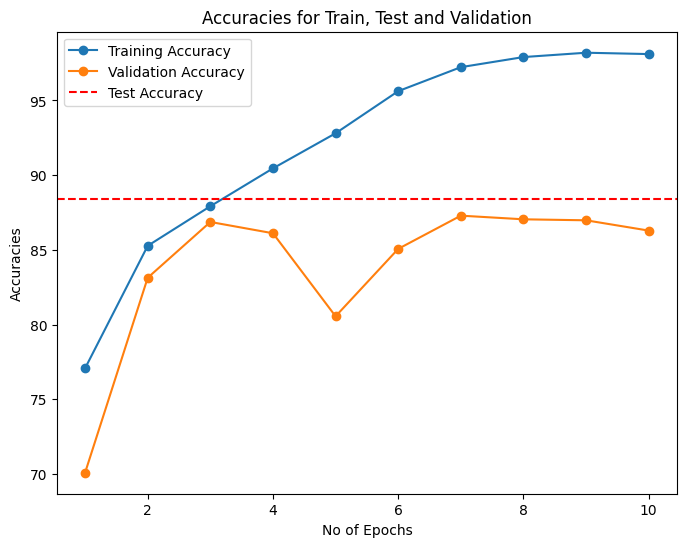

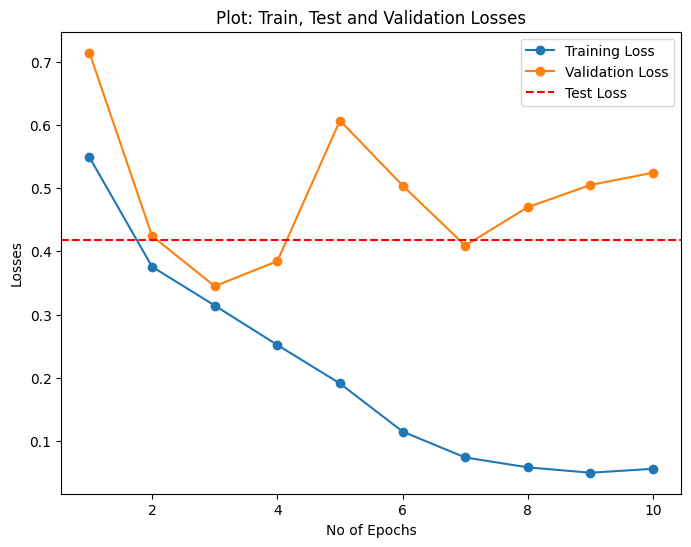

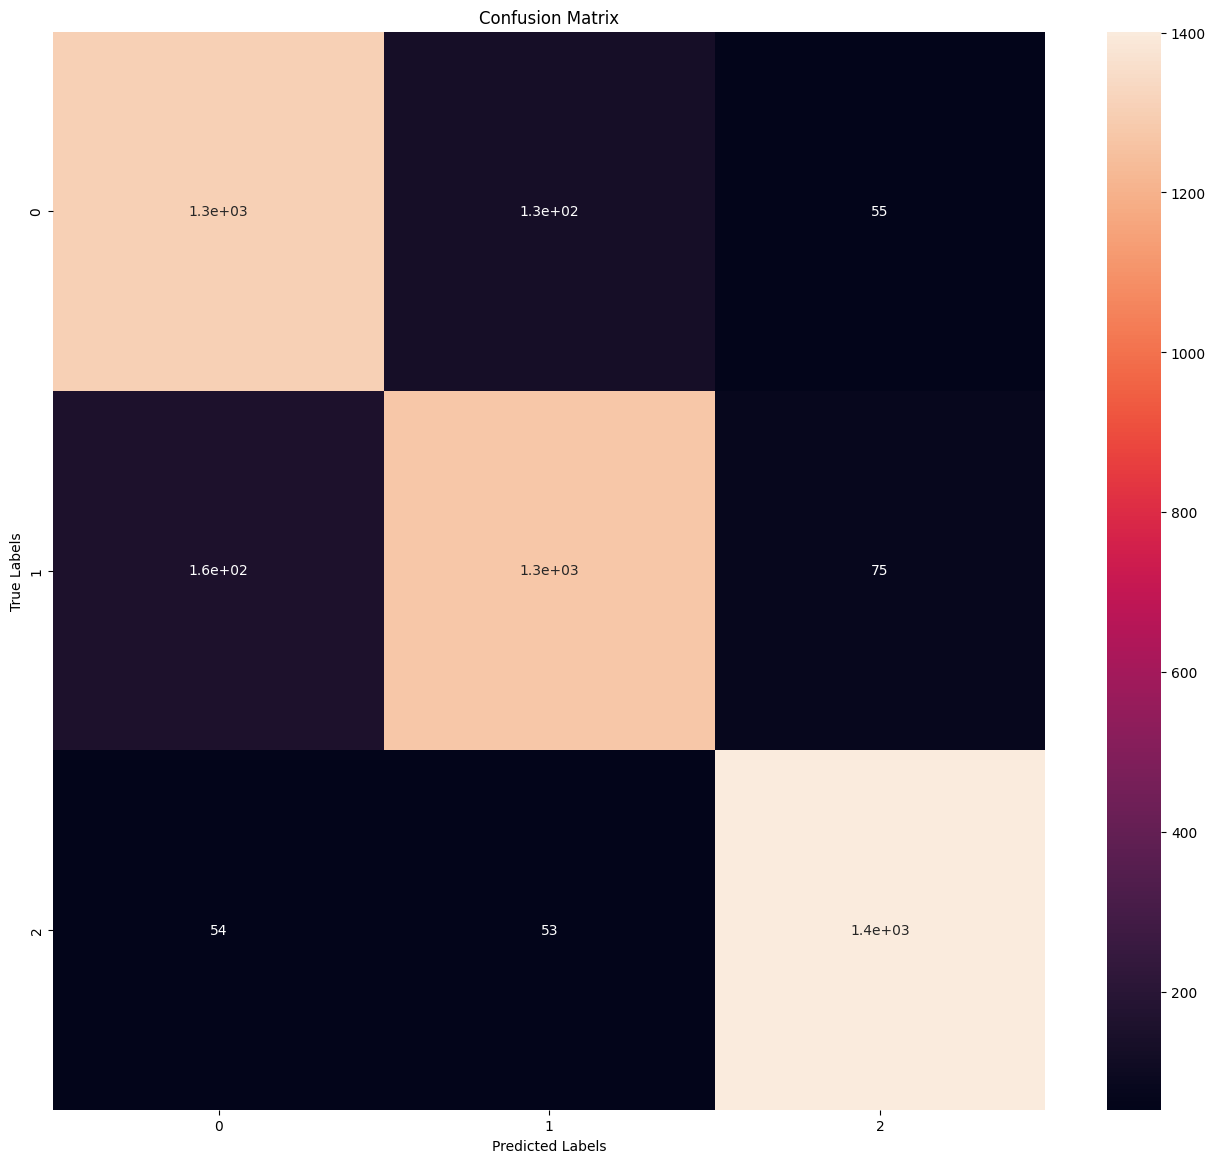

In [31]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 10)
print_losses_plot(train_losses, val_losses, test_average_loss, 10)
print_confusion_matrix(total_correct_pred, test_pred)

In [32]:
torch.save(best_early_resnet.state_dict(), 'cnara_neemageo_assignment1_part2.h5')